In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
token = WordPunctTokenizer()

In [2]:
import pandas as pd
training = pd.read_csv("../input/sentiment140/training.1600000.processed.noemoticon.csv",encoding = 'latin1')

In [3]:
columns = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv("../input/sentiment140/training.1600000.processed.noemoticon.csv",encoding = 'latin-1',header = None,names=columns)
df.drop(columns = ['id','date','query_string','user'],inplace = True)
df['sentiment'] = df['sentiment'].map({0:0,4:1})

In [4]:
username_hyper_link = r'@[A-Za-z0-9_]+|https?:\/\/[^ ]+'
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not",
                 "aren't":"are not",
                 "wasn't":'was not',
                 "weren't":'were not',
                 "haven't":"have not",
                 "hasn't":'has not',
                 "hadn't":"had not",
                 "won't":"will not",
                 "wouldn't":"would not",
                 "don't":"do not",
                 "doesn't":"does not",
                 "didn't":"did not",
                 "can't":"can not",
                 "couldn't":"could not",
                 "shouldn't":"should not",
                 "mightn't":"might not",
                 "mustn't":"must not"
    
}

def find_replace_multi_ordered(string,dictonary):
    for item in dictonary.keys():
        string = re.sub(item,dictonary[item],string)
    return string

In [5]:
neg_handeled = df['text'].apply(lambda x : find_replace_multi_ordered(x,negations_dic))

In [6]:
def improved_tweet_cleaner(text):
    soup = BeautifulSoup(text,'lxml')
    good_soup = soup.get_text()
    remove_latin_tokens = re.sub(r'ï¿½','?',good_soup)
    user_name_hyperlink = re.sub(username_hyper_link,'',remove_latin_tokens)
    www_removed = re.sub(www_pat,'',user_name_hyperlink)
    lower_case = www_removed.lower()
    letters_only = re.sub("[^a-zA-Z]"," ",lower_case) # this creates un-necessary white spaces so we will takel this by tokenization
    words = [x for x in token.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()


In [7]:
new_and_improved_clean_text = neg_handeled.apply(lambda x : improved_tweet_cleaner(x))

In [8]:
clean_tweets_again = pd.DataFrame(new_and_improved_clean_text,columns = ['text'])
clean_tweets_again['sentiment'] = df['sentiment']


In [9]:
clean_tweets_again.to_csv('clean_tweets_again.csv',encoding = 'utf8')

In [10]:
csv = 'clean_tweets_again.csv'

In [11]:
new_df = pd.read_csv(csv,index_col = 0)

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [12]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
text         1596041 non-null object
sentiment    1600000 non-null int64
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


In [13]:
new_df.isnull().sum()
# there are nearly 4000 rows in the data frame which are null
# the reason this are null because the only information they had was twitter id or a hyperlink or website link
# the sentiments of this tweets play no major role in sentimental analysis

text         3959
sentiment       0
dtype: int64

In [14]:
new_df.dropna(inplace = True)

In [15]:
new_df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [16]:
negative_tweets = new_df[new_df['sentiment'] == 0]
negative_string = []
for tweet in negative_tweets['text']:
    negative_string.append(tweet)
negative_string = pd.Series(negative_string).str.cat(sep = " ")

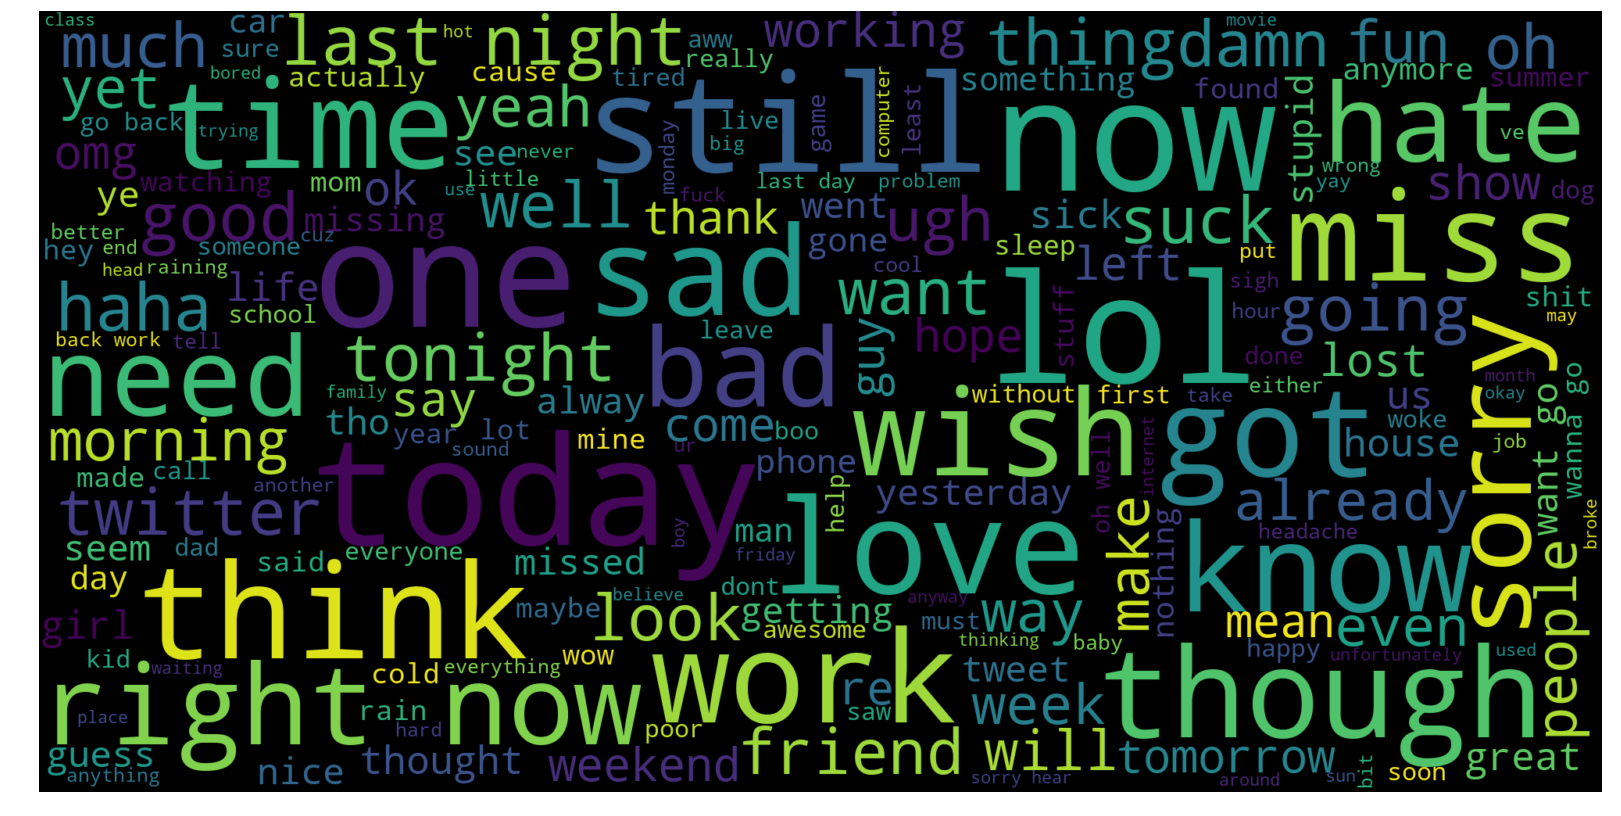

In [17]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 2000,
                      height = 1000,
                      max_font_size = 200).generate(negative_string)
plt.figure(figsize = (28,15))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [18]:
# from this we observe that most of the words that are big are neutral and most of the small words like damm ugh miss bad are 
# from the above word cloud we observe that word love is prevaling in the context of negative tweets
# even though the negative tweet contains love in this case the word love is mixed with mixed elements or sometimes the word love is used sarcastically
for tweet in negative_tweets['text'][:1000]:
    if 'love' in tweet:
        print(tweet)

ahh ive always wanted to see rent love the soundtrack
meh almost lover is the exception this track gets me depressed every time
awe love you too am here miss you
damn the grind is inspirational and saddening at the same time don want you to stop cuz like what do much love
missing you babe but as long as your alive happy ya tired my love imma try to sleep hopefully you had headstart
love the french tell people here in the south qtr french and they snarl at me french are beautiful people
ooh excited and not even going be there long love youtube
here friend and love you
wish was sold out if you have some time let me know would love to hear more about what you are up to
love you buck
is in love with scrappy and is missin him already
glad was able help you feel better hate to see you sick love you
love my atekinzz so much soo miss her
stupid arranged marriages ll convert so you can marry me love you
fuck omg austins always there though man love you
wahh no csi anywhere dvr ed love money tho

In [19]:
positive_tweets = new_df[new_df['sentiment'] == 1]
positive_strings = []
for tweet in positive_tweets['text']:
    positive_strings.append(tweet)
positive_strings = pd.Series(positive_strings).str.cat(sep = " ")

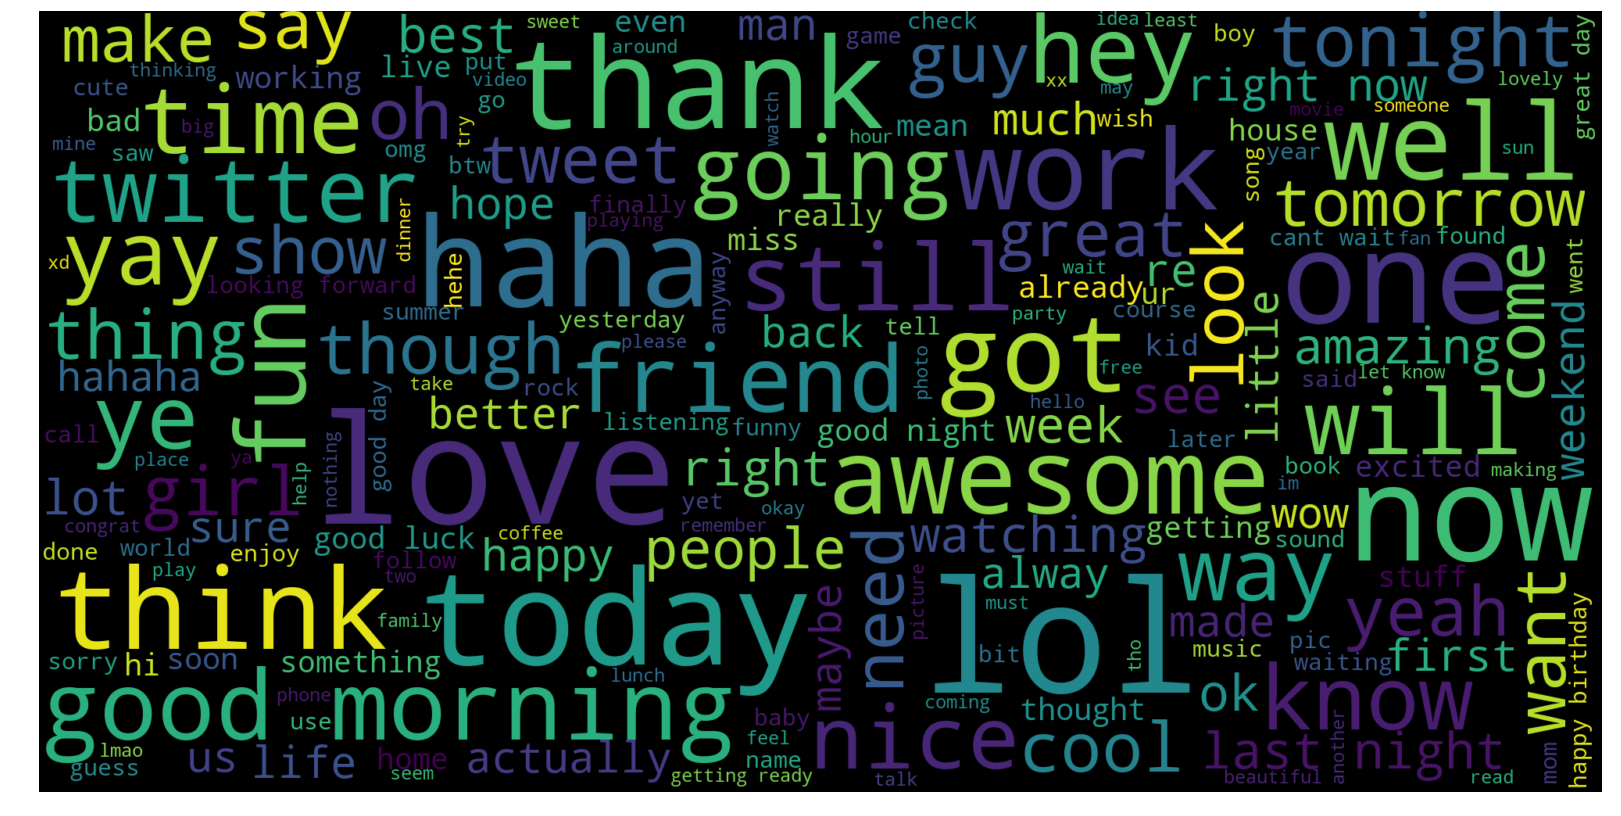

In [20]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 2000,
                      height = 1000,
                      max_font_size = 200,
                      colormap = 'viridis'
                     ).generate(positive_strings)
plt.figure(figsize = (28,15))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [21]:
# in this case we observe some neutral words like today,now but words like haha awesome also stand out
# we also observed that the word word was quite big in the negative word cloud but also quite big in the positive 
# word cloud this tells us that some people are positive about their word and some people are negative


**In order to implement data visualization we need term frequency data to find what to find what kind of words are used in the tweets and how many times it is used in the whole corpus **

In [22]:
# to find this frequencies we use the concept of stopwords
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer()
count_vec.fit(new_df['text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [23]:
len(count_vec.get_feature_names()) # there are like 264939 words in the corpus

264939

In [24]:
neg_doc_matrix = count_vec.transform(new_df[new_df['sentiment'] == 0]['text'])
#this gives a sparse matrix of all the features
pos_doc_matrix = count_vec.transform(new_df[new_df['sentiment'] == 1]['text'])
neg_tf = np.sum(neg_doc_matrix,axis = 0)
#in this statement we are calculating the sum of frequencies for each feature
pos_tf = np.sum(pos_doc_matrix,axis = 0)
neg = np.squeeze(np.array(neg_tf))
# the sum of frequency obtained is in matrix form so we convert the 2d matrix into 1d numpy array by removing the extra
#dimensions
pos = np.squeeze(np.array(pos_tf))
term_frequency_pandas_dataframe = pd.DataFrame([neg,pos],columns = count_vec.get_feature_names()).T


In [25]:
term_frequency_pandas_dataframe.columns = ['positive','negative']

In [26]:
term_frequency_pandas_dataframe['total'] = term_frequency_pandas_dataframe['positive'] + term_frequency_pandas_dataframe['negative']

In [27]:
term_frequency_pandas_dataframe.head()

,positive,negative,total
aa,160,92,252
aaa,93,54,147
aaaa,45,29,74
aaaaa,26,12,38
aaaaaa,16,12,28


In [28]:
len(term_frequency_pandas_dataframe)

264939

In [29]:
term_frequency_pandas_dataframe.to_csv('term_freq_df.csv',encoding = 'utf8')